# All Things Data

In [347]:
import os
import pandas as pd
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [348]:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

## Loading

In [349]:
emotions = {0:'no_emotion', 1:'anger', 2:'disgust', 3:'fear', 4:'happiness', 5:'sadness', 6:'surprise'}

In [350]:
dataset_directory_path = 'full_dataset'

dataframes = []

csv_files = [file for file in os.listdir(dataset_directory_path) if file.endswith('.csv')]

In [352]:
file_path = os.path.join(dataset_directory_path, 'isear.csv')
df = pd.read_csv(file_path)
df['Emotion'] = df['Emotion'].replace('joy', 'happiness')
df.rename(columns={'Emotion': 'emotion'}, inplace=True)
df.rename(columns={'Text': 'text'}, inplace=True)
dataframes.append(df)
df.emotion.value_counts()

emotion
happiness    1081
fear         1081
anger        1071
sadness      1067
disgust      1067
shame        1054
guilt        1052
Name: count, dtype: int64

In [353]:
file_path = os.path.join(dataset_directory_path, 'emotion-stimulus.csv')
df = pd.read_csv(file_path)
df['Emotion'] = df['Emotion'].replace('sad', 'sadness')
df['Emotion'] = df['Emotion'].replace('happy', 'happiness')
df.rename(columns={'Emotion': 'emotion'}, inplace=True)
df.rename(columns={'Text': 'text'}, inplace=True)
dataframes.append(df)
df.emotion.value_counts()

emotion
sadness      575
anger        483
happiness    479
fear         423
surprise     213
shame        146
disgust       95
Name: count, dtype: int64

In [354]:
merged_df = pd.concat(dataframes, axis=0, ignore_index=True)
merged_df.head(n=5)

,emotion,text
0,happiness,"During the period of falling in love, each tim..."
1,fear,When I was involved in a traffic accident.
2,anger,When I was driving home after several days of...
3,sadness,When I lost the person who meant the most to me.
4,disgust,The time I knocked a deer down - the sight of ...


In [355]:
print("Columns:")
for c in merged_df.columns.tolist():
    print("\t", c)

Columns:
	 emotion
	 text


In [356]:
print("All emotions:")
emotions = []
for e in merged_df['emotion'].unique():
    if e not in ['text', 'id']:
        print("\t", e)
        emotions.append(e)

All emotions:
	 happiness
	 fear
	 anger
	 sadness
	 disgust
	 shame
	 guilt
	 surprise


In [357]:
print("Number of rows = ", filtered_df.shape[0])

Number of rows =  112866


In [358]:
print("Number of columns = ", filtered_df.shape[1])

Number of columns =  2


## GoEmotions

In [410]:
dataset_directory_path = 'goemotions/full_dataset'
dataframes = []

for file in os.listdir(dataset_directory_path):
    if file not in ['full_dataset.csv'] and file.endswith('.csv'):
        df = pd.read_csv(os.path.join(dataset_directory_path, file))
        dataframes.append(df)

goemotions_data = pd.concat(dataframes, axis=0, ignore_index=True)

In [411]:
columns_to_drop = ['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear']
goemotions_data.drop(columns=columns_to_drop, inplace=True)

In [412]:
goemotions_data

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,Everyone likes [NAME].,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
211221,Well when you’ve imported about a gazillion of...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211222,That looks amazing,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211223,The FDA has plenty to criticize. But like here...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Preprocessing

In [359]:
def cleanText(text):
    text = text.lower()

    # Remove links
    text = re.sub(r"http\S*|\S*\.com\S*|\S*www\S*", " ", text)

    # Remove @mentions
    text = re.sub(r"\s@\S+", " ", text)

    # Remove all punctuation
    punctuation_table = str.maketrans("", "", string.punctuation)
    text = text.translate(punctuation_table)

    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    tokens = [token for token in tokens if len(token)>2]

    return tokens

In [413]:
tqdm.pandas(desc="Processing text")
dataframe = merged_df.copy()
dataframe['preprocessed_text'] = dataframe['text'].progress_apply(cleanText)
goemotions_data['preprocessed_text'] = goemotions_data['text'].progress_apply(cleanText)

Processing text: 100%|██████████| 211225/211225 [01:06<00:00, 3188.50it/s]


In [414]:
dataframe.rename(columns={'text': 'original_text'}, inplace=True)
dataframe.rename(columns={'preprocessed_text': 'text_tokens'}, inplace=True)
dataframe['preprocessed_text'] = dataframe['text_tokens'].apply(lambda x: ' '.join(x)).astype(str)

In [416]:
goemotions_data.rename(columns={'text': 'original_text'}, inplace=True)
goemotions_data.rename(columns={'preprocessed_text': 'text_tokens'}, inplace=True)
goemotions_data['preprocessed_text'] = goemotions_data['text_tokens'].apply(lambda x: ' '.join(x)).astype(str)

In [420]:
desired_order = ['original_text', 'text_tokens', 'preprocessed_text', 'admiration', 'amusement', 'anger', 'annoyance',
       'approval', 'caring', 'confusion', 'curiosity', 'desire',
       'disappointment', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse',
       'sadness', 'surprise', 'neutral']

goemotions_data = goemotions_data[desired_order]

In [395]:
dataframe

,emotion,original_text,text_tokens,preprocessed_text
0,happiness,"During the period of falling in love, each tim...","[period, falling, love, time, met, especially,...",period falling love time met especially met lo...
1,fear,When I was involved in a traffic accident.,"[involved, traffic, accident]",involved traffic accident
2,anger,When I was driving home after several days of...,"[driving, home, several, day, hard, work, moto...",driving home several day hard work motorist ah...
3,sadness,When I lost the person who meant the most to me.,"[lost, person, meant]",lost person meant
4,disgust,The time I knocked a deer down - the sight of ...,"[time, knocked, deer, sight, animal, injury, h...",time knocked deer sight animal injury helpless...
...,...,...,...,...
9882,shame,He gets real humiliated and has to leave .,"[get, real, humiliated, leave]",get real humiliated leave
9883,shame,They aimed for higher status jobs and felt hum...,"[aimed, higher, status, job, felt, humiliated,...",aimed higher status job felt humiliated unempl...
9884,shame,He cursed his lack of self-control ; he knew t...,"[cursed, lack, selfcontrol, knew, old, biddy, ...",cursed lack selfcontrol knew old biddy seen fe...
9885,shame,Sometimes I've thought I 'll never forget wha...,"[sometimes, ive, thought, never, forget, happe...",sometimes ive thought never forget happened co...


In [421]:
goemotions_data

,original_text,text_tokens,preprocessed_text,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,"[game, hurt]",game hurt,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,"[sexuality, grouping, category, make, differen...",sexuality grouping category make different oth...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!","[right, dont, care, fuck]",right dont care fuck,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,"[man, love, reddit]",man love reddit,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...","[name, nowhere, near, falcon]",name nowhere near falcon,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,Everyone likes [NAME].,"[everyone, like, name]",everyone like name,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
211221,Well when you’ve imported about a gazillion of...,"[well, imported, gazillion, country, get, seri...",well imported gazillion country get serious,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
211222,That looks amazing,"[look, amazing]",look amazing,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211223,The FDA has plenty to criticize. But like here...,"[fda, plenty, criticize, like, usually, critic...",fda plenty criticize like usually criticized h...,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [422]:
csv_path = 'full_dataset/full_dataset.csv'
dataframe.to_csv(csv_path, index=False)
print(f'DataFrame saved to: {csv_path}')

DataFrame saved to: full_dataset/full_dataset.csv


In [423]:
csv_path = 'goemotions/full_dataset/full_dataset.csv'
goemotions_data.to_csv(csv_path, index=False)
print(f'DataFrame saved to: {csv_path}')

DataFrame saved to: goemotions/full_dataset/full_dataset.csv


## EDA

In [424]:
csv_path = 'full_dataset/full_dataset.csv'

In [425]:
data = pd.read_csv(csv_path)

In [426]:
data.head(n=-1)

,emotion,original_text,text_tokens,preprocessed_text
0,happiness,"During the period of falling in love, each tim...","['period', 'falling', 'love', 'time', 'met', '...",period falling love time met especially met lo...
1,fear,When I was involved in a traffic accident.,"['involved', 'traffic', 'accident']",involved traffic accident
2,anger,When I was driving home after several days of...,"['driving', 'home', 'several', 'day', 'hard', ...",driving home several day hard work motorist ah...
3,sadness,When I lost the person who meant the most to me.,"['lost', 'person', 'meant']",lost person meant
4,disgust,The time I knocked a deer down - the sight of ...,"['time', 'knocked', 'deer', 'sight', 'animal',...",time knocked deer sight animal injury helpless...
...,...,...,...,...
9881,shame,` When Liz came back there was raucous laughte...,"['liz', 'came', 'back', 'raucous', 'laughter',...",liz came back raucous laughter felt humiliated
9882,shame,He gets real humiliated and has to leave .,"['get', 'real', 'humiliated', 'leave']",get real humiliated leave
9883,shame,They aimed for higher status jobs and felt hum...,"['aimed', 'higher', 'status', 'job', 'felt', '...",aimed higher status job felt humiliated unempl...
9884,shame,He cursed his lack of self-control ; he knew t...,"['cursed', 'lack', 'selfcontrol', 'knew', 'old...",cursed lack selfcontrol knew old biddy seen fe...


In [367]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9887 entries, 0 to 9886
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   emotion            9887 non-null   object
 1   original_text      9887 non-null   object
 2   text_tokens        9887 non-null   object
 3   preprocessed_text  9887 non-null   object
dtypes: object(4)
memory usage: 309.1+ KB


In [368]:
data = data.dropna(subset=['preprocessed_text'])

In [369]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9887 entries, 0 to 9886
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   emotion            9887 non-null   object
 1   original_text      9887 non-null   object
 2   text_tokens        9887 non-null   object
 3   preprocessed_text  9887 non-null   object
dtypes: object(4)
memory usage: 309.1+ KB


In [370]:
data.to_csv(csv_path, index=False)
print(f'DataFrame saved to: {csv_path}')

DataFrame saved to: full_dataset/full_dataset.csv


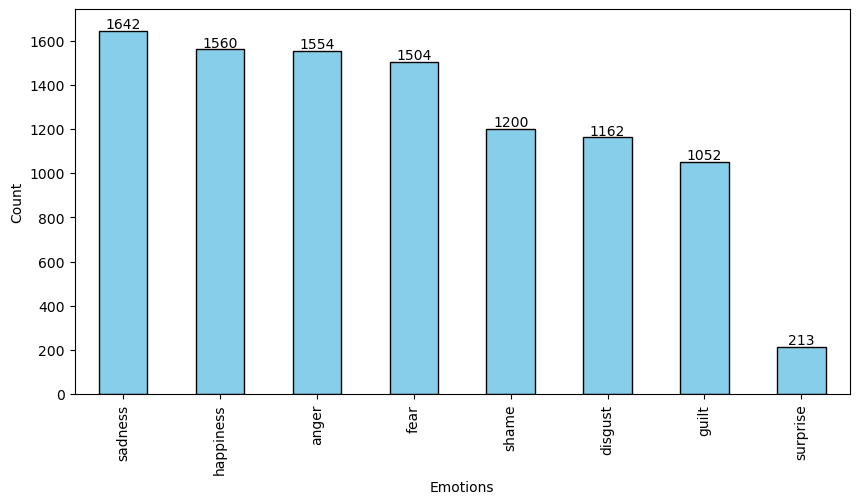

In [371]:
plt.figure(figsize=(10, 5))

emotion_counts = data['emotion'].value_counts()

ax = emotion_counts.plot(kind='bar', color='skyblue', edgecolor='black')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()+12), ha='center', va='baseline')

plt.ylim(0, max(emotion_counts) + 100)
plt.xlabel('Emotions')
plt.ylabel('Count')

plt.show()

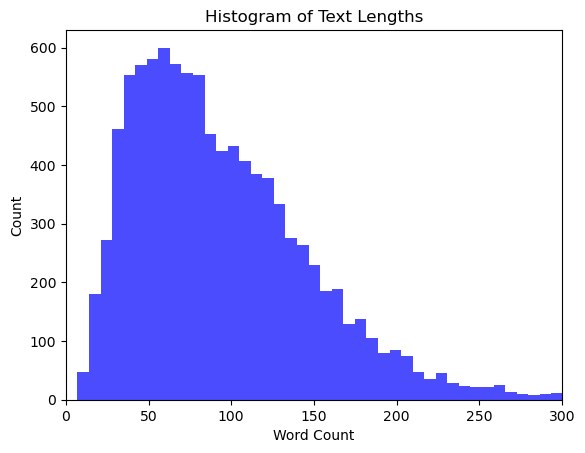

In [372]:
text_length = data['text_tokens'].apply(len)

plt.hist(text_length, bins=100, color='blue', alpha=0.7)
plt.xlim(0, 300)
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.title('Histogram of Text Lengths')
plt.show()

### GoEmotions

In [427]:
csv_path = 'goemotions/full_dataset/full_dataset.csv'
data = pd.read_csv(csv_path)
data.head(n=-1)

,original_text,text_tokens,preprocessed_text,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,"['game', 'hurt']",game hurt,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,"['sexuality', 'grouping', 'category', 'make', ...",sexuality grouping category make different oth...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!","['right', 'dont', 'care', 'fuck']",right dont care fuck,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,"['man', 'love', 'reddit']",man love reddit,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...","['name', 'nowhere', 'near', 'falcon']",name nowhere near falcon,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211219,"Well, I'm glad you're out of all that now. How...","['well', 'glad', 'youre', 'awful', 'way', 'act...",well glad youre awful way act make think healt...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211220,Everyone likes [NAME].,"['everyone', 'like', 'name']",everyone like name,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
211221,Well when you’ve imported about a gazillion of...,"['well', 'imported', 'gazillion', 'country', '...",well imported gazillion country get serious,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
211222,That looks amazing,"['look', 'amazing']",look amazing,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [428]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211225 entries, 0 to 211224
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   original_text      211225 non-null  object
 1   text_tokens        211225 non-null  object
 2   preprocessed_text  210553 non-null  object
 3   admiration         211225 non-null  int64 
 4   amusement          211225 non-null  int64 
 5   anger              211225 non-null  int64 
 6   annoyance          211225 non-null  int64 
 7   approval           211225 non-null  int64 
 8   caring             211225 non-null  int64 
 9   confusion          211225 non-null  int64 
 10  curiosity          211225 non-null  int64 
 11  desire             211225 non-null  int64 
 12  disappointment     211225 non-null  int64 
 13  disapproval        211225 non-null  int64 
 14  disgust            211225 non-null  int64 
 15  embarrassment      211225 non-null  int64 
 16  excitement         2

In [429]:
data = data.dropna(subset=['preprocessed_text'])

In [430]:
data.to_csv(csv_path, index=False)
print(f'DataFrame saved to: {csv_path}')

DataFrame saved to: goemotions/full_dataset/full_dataset.csv


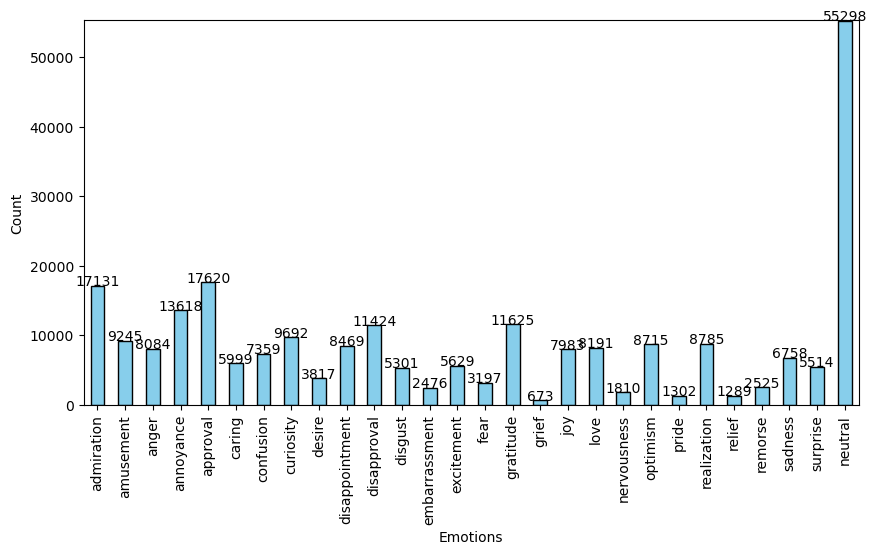

In [432]:
plt.figure(figsize=(10, 5))

emotion_counts = goemotions_data.drop(columns=['original_text', 'text_tokens', 'preprocessed_text'], axis=1).sum()

ax = emotion_counts.plot(kind='bar', color='skyblue', edgecolor='black')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()+12), ha='center', va='baseline')

plt.ylim(0, max(emotion_counts) + 100)
plt.xlabel('Emotions')
plt.ylabel('Count')

plt.show()